In [2]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs')

from torchvision import datasets, transforms

In [3]:
writer.flush()

<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center"> Friday Fashion Challenge</h2>
    <h2 align="center" style="color:#01ff84"> Pytorch and Fashion-MNIST</h2>
<br>
<div>
You'll be using the <a href="https://github.com/zalandoresearch/fashion-mnist" style="color:#01ff84>"> Fashion-MNIST dataset</a>
, a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.
</div>
<img src='https://res.cloudinary.com/practicaldev/image/fetch/s--tGTLvoST--/c_imagga_scale,f_auto,fl_progressive,h_720,q_auto,w_1280/https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png' width=500px>
    
<div> 
<br>
Download and import the dataset


In [4]:
import torch
from torchvision import datasets, transforms
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, drop_last=True)

<div style="background:#222222; color:#ffffff; padding:20px">
  <strong style="color:#01ff84">Helper functions</strong>
  <p>1. Visualize a torch vector and a sample prediction:</p>
<div>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


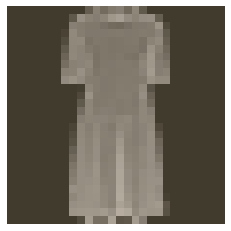

In [6]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

## Defining the model

In [7]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 10)
        self.do = nn.Dropout(0.2, inplace=True)

    def forward(self, x):
        x = F.relu(self.do(self.bn1(self.fc1(x))))  #self.do(self.bn1(
        x = F.relu(self.do(self.bn2(self.fc2(x))))  #self.do(self.bn2(
        x = F.relu(self.do(self.bn3(self.fc3(x))))  #self.do(self.bn3(
        x = F.relu(self.do(self.bn4(self.fc4(x))))  #self.do(self.bn4(
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()

In [8]:
class Fashion(nn.Module):
    def __init__(self):
        super(Fashion, self).__init__()
        self.conv1 = nn.Conv2d(1, 15, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(15, 30, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(1080, 100)
        self.fc2 = nn.Linear(100, 10)
        self.do = nn.Dropout(0.1, inplace=True)
        
    def forward(self, x):
        x = F.relu(self.do(self.conv1(x)))
        x = F.relu(F.max_pool2d(self.do(self.conv2(x))), 2, stride=2)
        x = x.view(-1, 1080)
        x = F.relu(self.do(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model1 = Fashion()

## Training the model

In [9]:
# #Setting up CUDA
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [1]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 50
train = []
test = []
start_time = time.time()

for epoch in range(epochs):
    #set running_loss variables
    running_loss = 0
    running_loss_test = 0
    incorrect = []
    print(f'Epoch: {epoch+1}/{epochs}')

    model.train()
    for i, (images, labels) in enumerate(iter(trainloader)):
        # images, labels = images.to(device), labels.to(device)
        images.resize_(images.size()[0], 784)

        optimizer.zero_grad()

        pred = model.forward(images)
        # pred = F.softmax(logits, dim=1)
        train_loss = criterion(pred, labels)
        train_loss.backward()
        optimizer.step()

        running_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):

            images.resize_(images.size()[0], 784)
            test_probs = model.forward(images)
            test_loss = criterion(test_probs, labels)
            _, pred = test_probs.topk(1, dim=1)
            incorrect_pred = ((pred == labels) == False).nonzero()
            running_loss_test += test_loss.item()
            incorrect.append(images[incorrect_pred].numpy())
    train.append((running_loss/len(trainloader)))
    test.append((running_loss_test/len(testloader)))

train_time = time.time() - start_time
print(f'Training time: {train_time}')

plt.plot(train, label='train loss')
plt.plot(test, label='test loss')
plt.legend()
plt.show()

NameError: name 'nn' is not defined

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

<Figure size 1440x576 with 0 Axes>

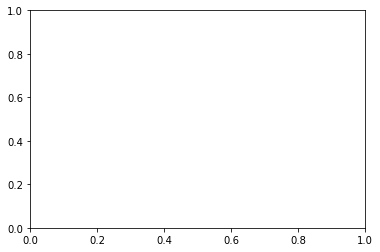

In [12]:
figure = plt.figure(figsize=(20, 8))
for false in np.arange(len(incorrect)):
    img = incorrect[false][false]
    imshow(img)

In [ ]:
# READ HERE! This is just a snippet of the code that can help you. The model has not been
# defined above, so if you run this cell you should get an error. This is just to show you
# what the output of the function looks like

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
dataiter = iter(testloader)
images, labels = dataiter.next()
images.resize_(64, 1, 784)
img = images[1]

ps = model(img) # ps stands for probabilities: your model should return values between 0 and 1
# that sums to 1. A softmax does this job!
_, topclass = ps.topk(1, dim=1)
print(topclass)
# Plot the image and probabilities
view_classify(img, ps, version='Fashion')

<div style="background:#222222; color:#ffffff; padding:20px">
    <h3 align="center"> TIPS for the validation part</h3>
<br>
<div>
  <strong style="color:#01ff84">Visualize the most likely class</strong>
  <p>With the probabilities, we can get the most likely class using the <code>ps.topk</code> method. This returns the $k$ highest values. Since we just want the most likely class, we can use <code>ps.topk(1)</code>. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.:</p>
<div>

In [ ]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(batch_size, 1)` while `labels` is 1D with shape `(batch_size)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(batch_size, batch_size)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 (or your batch size) True/False boolean values for each row.

In [ ]:
equals = top_class == labels.view(*top_class.shape)

If you want to see the indexes of the misclassified images in the batch, you can run the following:

In [ ]:
misclassified = [index for index,value in enumerate(equals) if value.item() is False] 


Then you can use those indices to index `images[...]`!

<div style="background:#222222; color:#ffffff; padding:20px">
  <strong style="color:#01ff84">Compute the accuracy</strong>
  

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [ ]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Remember that when you do operations over the weights, both in the forward pass and in the optimization step, Pytorch keeps track of them and `autograd`, that is a Pytorch module for automatically calculating the gradients of tensors, will compute the gradient of them! This is useful when you have to perform the backward pass as well, but not for the validation!

Why?

The reason you compute the gradient is that you want to minimize the loss function, and the gradient allows you to find in which "direction" you have to adjust the weights to reach the minumum of the loss function. 

So this is a step you perform in the training loop, because you want to adjust and learn the weights. In the validation, you use the weights you've learned so far to test how the model is performing, so you don't need to either update the weights or to compute the gradients!

You can use a "context manager" to turn off the gradients while doing the validation step:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

<div style="background:#222222; color:#ffffff; padding:20px">
  <strong style="color:#01ff84">CAVEAT</strong>
<ul>
 <li> Remember to reset the gradients of the optimizer in the training loop! <br>
    <code> optimizer.zero_grad()
    loss.backward()
    optimizer.step()</code>
    </li>
 <li> Be careful about the nn.CrossEntropyLoss(): it wants the raw logits as inputs, and not the output of the softmax! I recommend you to use the <code>LogSoftmax</code> as last layer of your network, and the <code>nn.NLLLoss()</code> as criterion. However, to have the probabilities (the ps in the code) you must use <code>torch.exp(output)</code> since the <code>LogSoftmax</code> gives the log of the probabilities!
 </ul>
    
</div>
  

<div style="background:#222222; color:#ffffff; padding:20px">
   <h3 align="center" style="color:#01ff84"> Save and load a model</h3>
    
The simplest thing to do is simply save the state dict with <code>torch.save</code>. For example, we can save it to a file <code>'checkpoint.pth'</code>.

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

<div style="background:#222222; color:#ffffff; padding:20px">
    Then we can load the state dict with <code>torch.load</code>.

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

<div style="background:#222222; color:#ffffff; padding:20px">

And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [ ]:
model.load_state_dict(state_dict)

<div style="background:#222222; color:#ffffff; padding:20px">

This works only if you have recreated the same exact model (with same layers and so on) and stored it in model, so that it can load the needed information!

If you want also to save the epoch and the state of the optimizer, for example, read here https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html.

   <h3 align="center" style="color:#01ff84"> Good luck! 🤞</h3>